<h2>
<center>Crypto/Stock Pair Trading using ML techniques</center>
</h2>

<h4>
<center>Applying dimensionality reduction and clustering to crypto and stock and performing pair selection through Sarmento and Horta criterias: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a></center>
</h4>



## Introduction

The goal is to attempt to construct a mean-reverting portfolio of cryptocurrency pairs. As a result alpha can be achieved by opening positions by taking positions when the spread is above/below a desired threshold from the mean.

One key problem arrising from this strategy is that the amount of potential pairs to monitor increases exponentially as more assets are added. This is where ML techniques can help solve some of these issues.

Sarmento and Horta present an unsupervised clustering approach to find securities for pairs trading in their book: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a>. The main ideas are the following: dimensionality reduction through principal components, clustering of PC, and application of statistical criterias such as coinegration / mean reversion to price series.

## 1) Libs / Modules installation

In [56]:
# import the module we created

from pair_trading import PCA_Clustering_Pair_Strategy

# data visusalisation / manipulation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Sklean and statsmodel used mainly for PCA and clustering

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA as skPCA
from sklearn.cluster import OPTICS

from statsmodels.multivariate.pca import PCA as PCA
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts


# date time 

import datetime
from dateutil.relativedelta import relativedelta

# import warnings

from itertools import combinations, chain
import warnings

## 2) Import pre filtered Data

Data was collected from...

In [64]:
# importing the excel file that we have already pre cleaned

crypto_df = pd.read_excel('Data/crypto_dataset_2.xlsx')

crypto_df['date'] = pd.to_datetime(crypto_df['Date'])
crypto_df.drop(columns='Date', axis=1, inplace=True)

crypto_df.dropna(inplace=True)

# importing stock data already pre treated

stock_df = pd.read_excel('Data/stock_prices.xlsx')
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df.dropna(inplace=True)

full_df = pd.merge(crypto_df,stock_df, how='inner', on='date')

# full_df = crypto_df


full_df.set_index('date', inplace=True)

full_df.head(2)

,ACT-USD,ADA-USD,ADK-USD,ADX-USD,AE-USD,AIB-USD,AION-USD,ALIAS-USD,AMB-USD,ANT-USD,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,0.034675,0.084469,7.25921,0.203599,1.07549,0.010072,0.422602,0.229776,0.143674,0.860702,...,119.444443,41.970196,68.023567,36.193287,76.599892,83.850571,122.715683,173.199997,43.830067,89.077118
2018-10-02,0.032916,0.082525,8.12615,0.198655,1.05488,0.012896,0.423568,0.252648,0.142572,0.824521,...,118.033493,42.531349,68.538826,36.001167,76.381439,83.442551,122.123543,168.990005,43.706280,89.242317


<AxesSubplot:xlabel='date'>

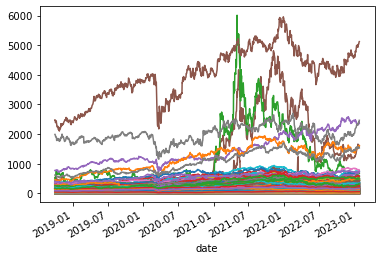

In [65]:
full_df.plot(legend=False)

In [66]:
sum(full_df.isna().sum())

0

## 3) Let's Explain the strategy:


In this part we use the full return dataset set just as an exemple of the methodology used.

### 3.1 Dimensionality Reduction with PCA

- Perform PCA

In [67]:
# computing the returns 

prices = full_df
securities = prices.columns
returns = prices.pct_change()[1:]


# Part 1) Using PCA to reduce dimensions of our returns

# Normalization of the returns
returns_n = preprocessing.scale(returns)

# Factorization of N components
pca_out = PCA(returns_n)

# Eigenvalues
pca_eval = pca_out.eigenvals

# Eigenvectors
pca_evec = pca_out.eigenvecs

# % of explained variance
pca_var = pca_eval/np.sum(pca_eval)

# Cumulated explained variance
pca_var_c = np.cumsum(pca_var)

# Principal components
pca_comp = pca_out.factors

# Correlation of principal components
corr = np.corrcoef(pca_comp,rowvar=0)

- Choosing right number of PCs:

Criteria 1: Explained Variance plot

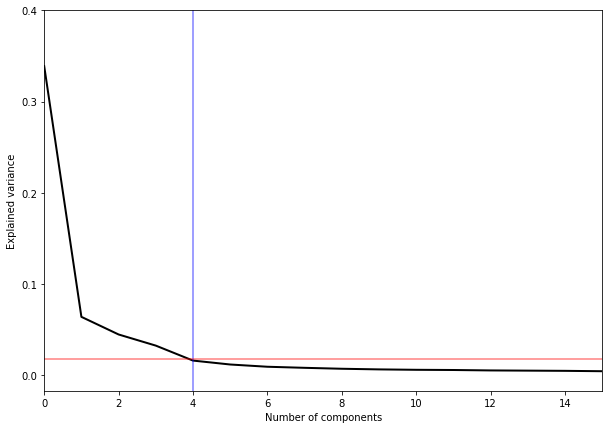

In [68]:
plt.figure(figsize=(10,7))
plt.plot(pca_var, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xlim(0, 15)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.axvline(4, c='b', alpha = 0.5)
plt.axhline(0.018, c='r', alpha = 0.5)
plt.show();

Criteria 2: Cumulative Explained Variance plot

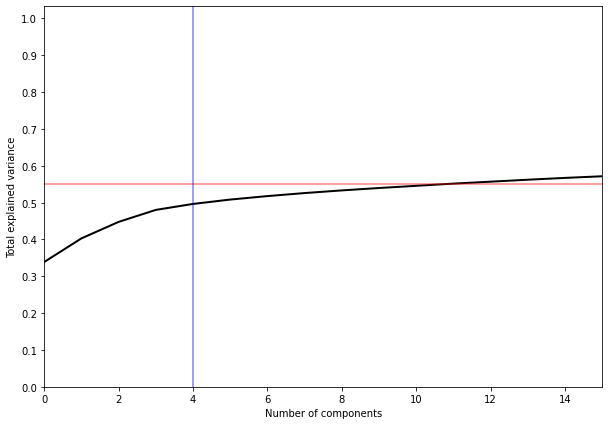

In [69]:
plt.figure(figsize=(10,7))
plt.plot(pca_var_c, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 15)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(4, c='b', alpha = 0.5)
plt.axhline(0.55, c='r', alpha = 0.5)
plt.show();

Criteria 3: BAI And NG IC Criteria

2 out of 3 at the 10th PC --> lets select 10 PC

In [72]:
pca_ic = pd.DataFrame(pca_out.ic)

pca_ic.head(15)

,0,1,2
0,13.476732,13.476732,13.476732
1,13.077700,13.078853,13.072893
2,12.990448,12.992754,12.980833
3,12.927209,12.930667,12.912787
4,12.881135,12.885745,12.861905
5,12.864232,12.869995,12.840195
6,12.855066,12.861982,12.826221
7,12.850438,12.858507,12.816786
8,12.847912,12.857133,12.809452
9,12.847282,12.857655,12.804014


In [74]:
# we implement our strategy using the skLearn package for more consistency and ability to set a random state

# let s set the nmb of components = 13

n_components_ = 10

# PCA pipeline
pipe = Pipeline([
    # in this case we use standard scaler
    ('scaler', StandardScaler()),
    # Perform PCA on scaled returns
    ('pca', skPCA(n_components = n_components_, random_state = 42)) # we set random state = 42 to obtain consistent results
    ])

returns_reduced = pipe.fit_transform(returns)
components_ = pipe['pca'].components_
n_components_ = pipe['pca'].n_components_

Visualisation of first 5 PCA loadings

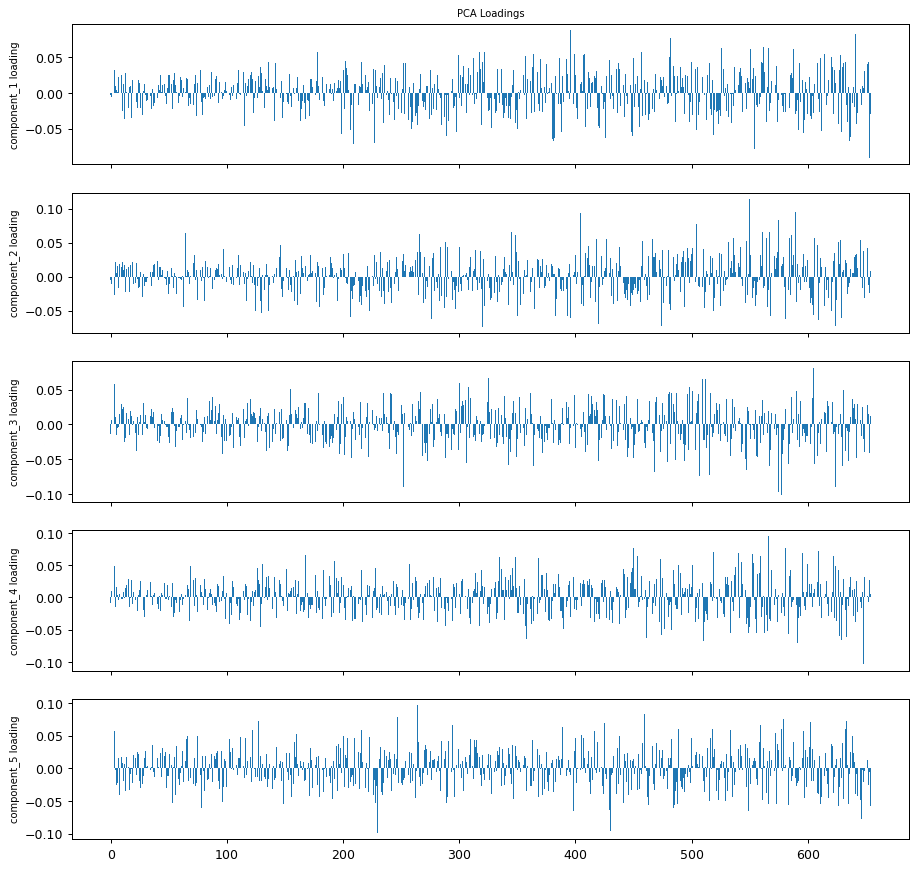

In [75]:
nmb_loadings_plots = 5

fig, axs = plt.subplots(nmb_loadings_plots , 1, sharex=True, figsize=(12, 12), dpi = 90)
fontsize = 8

for i in range(nmb_loadings_plots):
    
    axs[i].bar([i for i in range(pca_comp.shape[1])], pca_comp[i])
    axs[i].set_ylabel('component_'+str(i+1)+' loading', fontsize=fontsize)
    axs[0].set_title('PCA Loadings', fontsize=fontsize)

### 3.2 Clustering the Principal Components to find similar potential pairs

- We perform Clustering on PC using OPTICS algo

In [76]:
# Initialize and fit OPTICS cluster to PCA components
clustering = OPTICS()
clustering.fit(components_.T)

# Create cluster data frame and identify trading pairs
clusters = pd.DataFrame({'security': securities, 'cluster': clustering.labels_})
        
# Clusters with label == -1 are 'noise'

clusters = clusters[clusters['cluster'] != -1]

# Group securities by cluster and flatten list of combination lists
groups = clusters.groupby('cluster')
combos = list(groups['security'].apply(combinations, 2))  # All pairs
pairs = list(chain.from_iterable(combos))  # Flatten list of lists

print(f"Found {len(pairs)} potential pairs")

pairs = pd.Series(pairs)
cluster_labels = clustering.labels_

Found 768 potential pairs


- Representation of the PC 1 and 2

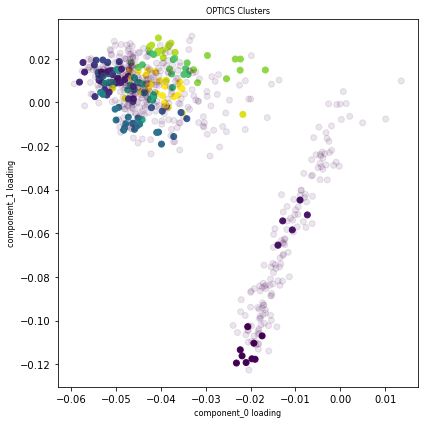

In [77]:
fontsize = 8
figsize = (6, 6)

fig, axs = plt.subplots(1, 1, figsize=figsize)
axs.scatter(components_[0].T[cluster_labels != -1],
            components_[1].T[cluster_labels != -1],
            c=cluster_labels[cluster_labels != -1])
axs.scatter(components_[0].T[cluster_labels == -1],
            components_[1].T[cluster_labels == -1],
            c=cluster_labels[cluster_labels == -1],
            alpha=0.1)
axs.set_title('OPTICS Clusters', fontsize=fontsize)
axs.set_xlabel('component_0 loading', fontsize=fontsize)
axs.set_ylabel('component_1 loading', fontsize=fontsize)
fig.tight_layout()

- Representation of the PC 1, 2 and 3

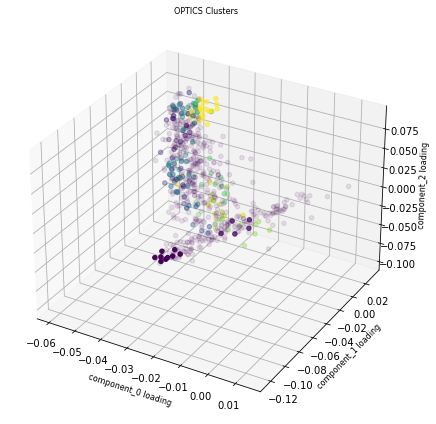

In [78]:
fig = plt.figure(figsize=figsize)
axs = fig.add_subplot(111, projection='3d')
axs.scatter(components_[0].T[cluster_labels != -1],
            components_[1].T[cluster_labels != -1],
            components_[2].T[cluster_labels != -1],
            c=cluster_labels[cluster_labels != -1])
axs.scatter(components_[0].T[cluster_labels == -1],
            components_[1].T[cluster_labels == -1],
            components_[2].T[cluster_labels == -1],
            c=cluster_labels[cluster_labels == -1],
            alpha=0.1)
            
axs.set_title('OPTICS Clusters', fontsize=fontsize)
axs.set_xlabel('component_0 loading', fontsize=fontsize)
axs.set_ylabel('component_1 loading', fontsize=fontsize)
axs.set_zlabel('component_2 loading', fontsize=fontsize)
fig.tight_layout()

### 3.3 Pair Selection following Sarmento and Horta study

Filter pairs based on:

#### 1. Cointegration test on each pair using Engle-Granger p-value
            
Eliminate potential pairs with Engle-Granger t-stat pvalues above max_pvalue of 5%.


If $x_t$ and $y_t$ are non-stationary and order of integration d=1, then a linear combination of them must be stationary for some value of $\beta$ and $\mu_t$.   
<br>
<center> $y_t - \beta x_t = \mu_t$ ; where $\mu_t$ is stationary. </center>




#### 2. Hurst Exponent Calculation

Values below 0.5 represent mean-reverting pairs.


Measure the long-term memory of a time series.

https://en.wikipedia.org/wiki/Hurst_exponent


<br>
<center> $\begin{aligned} \mathbb{E}\big[\frac{R(n)}{S(n)}\big] = Cn^H , n \rightarrow \infty\end{aligned}$</center>
$R(n)$ is the range of the first $n$ cumulative deviations from the mean.  
$S(n)$ is the series of the first $n$ standard deviations.  
$\mathbb{E}$ is the expected value.  
$n$ is the number of observations in the time series.  
$C$ is a constant.  




#### 3. Half-life Calculation

Eliminate pairs if no mean reversion after x days. Here we set to 252.


Amount of time it takes for a series to return to half its initial value.

<br>
<center> $\begin{aligned} N(t) = N_0e^{-\lambda t} \end{aligned}$</center>
$N_0$ is the initial quantity of the spread that will decay.  
$N(t)$ is the quantity that still remains and has not yet decayed after a time $t$.  
$\lambda$ is a positive number called the decay constant.  

The half-life, $t_{1/2}$ is defined as:
<center> $\begin{aligned} t_{1/2} = \frac{ln(2)}{\lambda} \end{aligned}$</center>


Spreads with short half-lives indicate portfolios that revert to the mean often and create many trading opportunities.




#### 4. Average Cross Count

Eliminate potential pairs based on the average number of instances per year the normalized spread of potential pairs crosses the mean.
Authors recommend trading pairs that cross mean on average 12 times per year

## 4) Creating a test train split

<AxesSubplot:xlabel='date'>

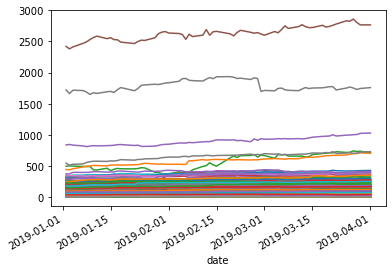

In [89]:
# create date elements

train_start = datetime.date(2019, 1, 1)
train_end = train_start + relativedelta(months=3)

test_start = train_end + relativedelta(days=1)
test_end = test_start + relativedelta(months=3)


# train / test df

train_df = full_df[train_start:train_end] # formation period
test_df = full_df[test_start:test_end] # trading period

train_df.plot(legend=False)

In [86]:
strategy = PCA_Clustering_Pair_Strategy(train_df, 4)

Found 845 potential pairs


In [87]:
strategy.perform_selection()

Found 34 tradable pairs!
                     pair    pvalue  hurst_exp  half_life  avg_cross_count
19    (LBC-USD, WAXP-USD)  0.019201   0.052036   4.331407            43.80
20     (LBC-USD, XDN-USD)  0.006240   0.021522   2.952458            46.72
65    (WAXP-USD, XDN-USD)  0.010114  -0.061576   3.444766            61.32
84     (BTX-USD, FIL-USD)  0.016801   0.086340   3.484129            43.80
94     (FIL-USD, UNO-USD)  0.005145  -0.027694   2.874886            49.64
114   (DGD-USD, TRUE-USD)  0.043370  -0.146463   4.226928            23.36
139  (COLX-USD, USDT-USD)  0.006049   0.075682   3.602186            78.84
140   (FRST-USD, HNC-USD)  0.027090   0.024005   2.086220            67.16
183           (CSX, TROW)  0.023288   0.103520   3.597086            52.56
188             (J, TROW)  0.031260   0.041131   4.151409            43.80
286            (IBM, OKE)  0.002429   0.000724   2.832451            55.48
390             (HPE, ON)  0.006730  -0.013417   4.643882            61.32


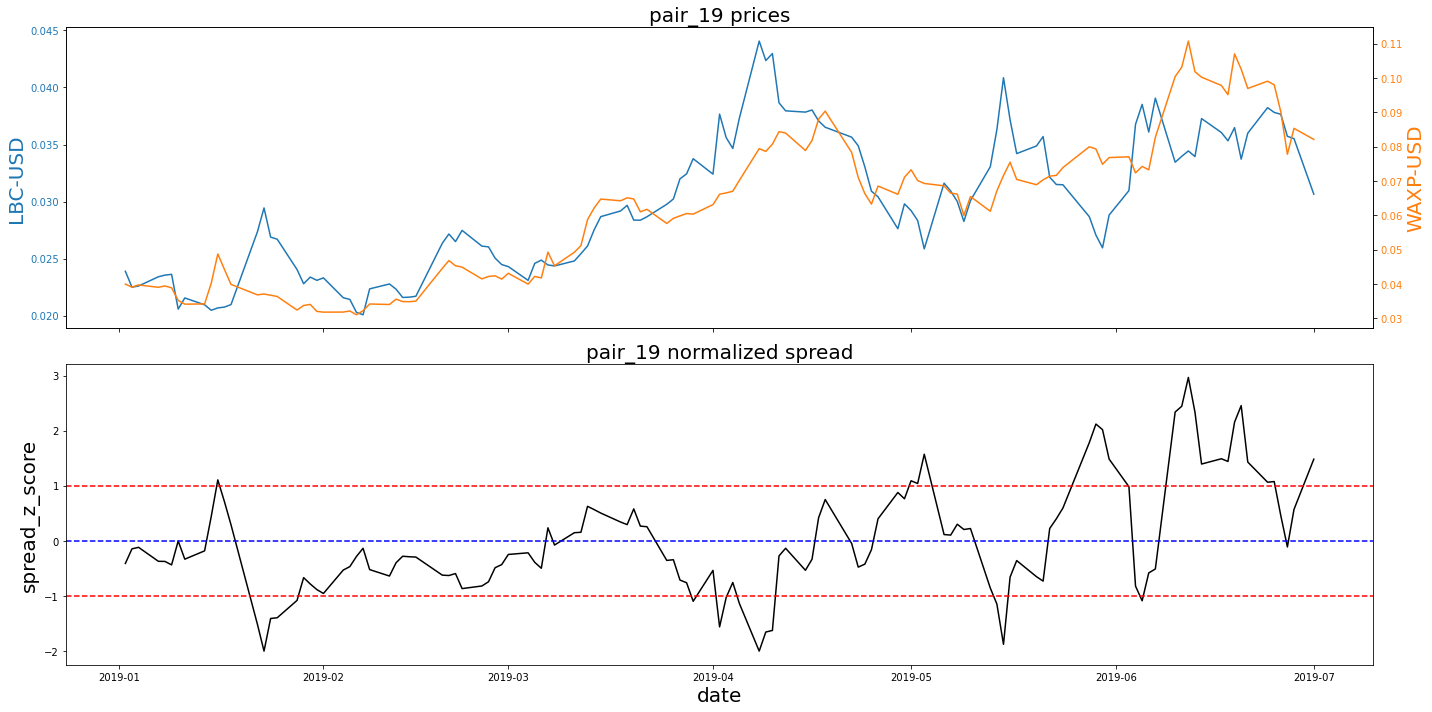

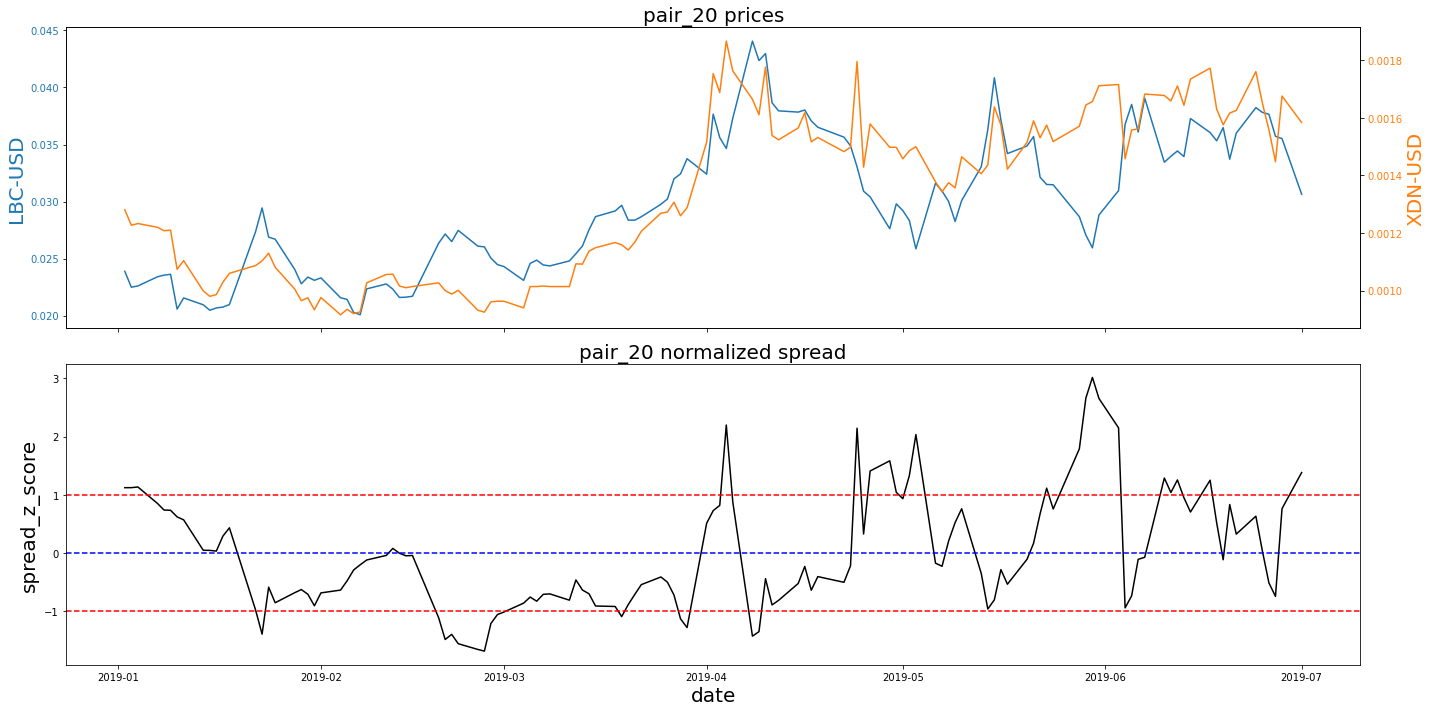

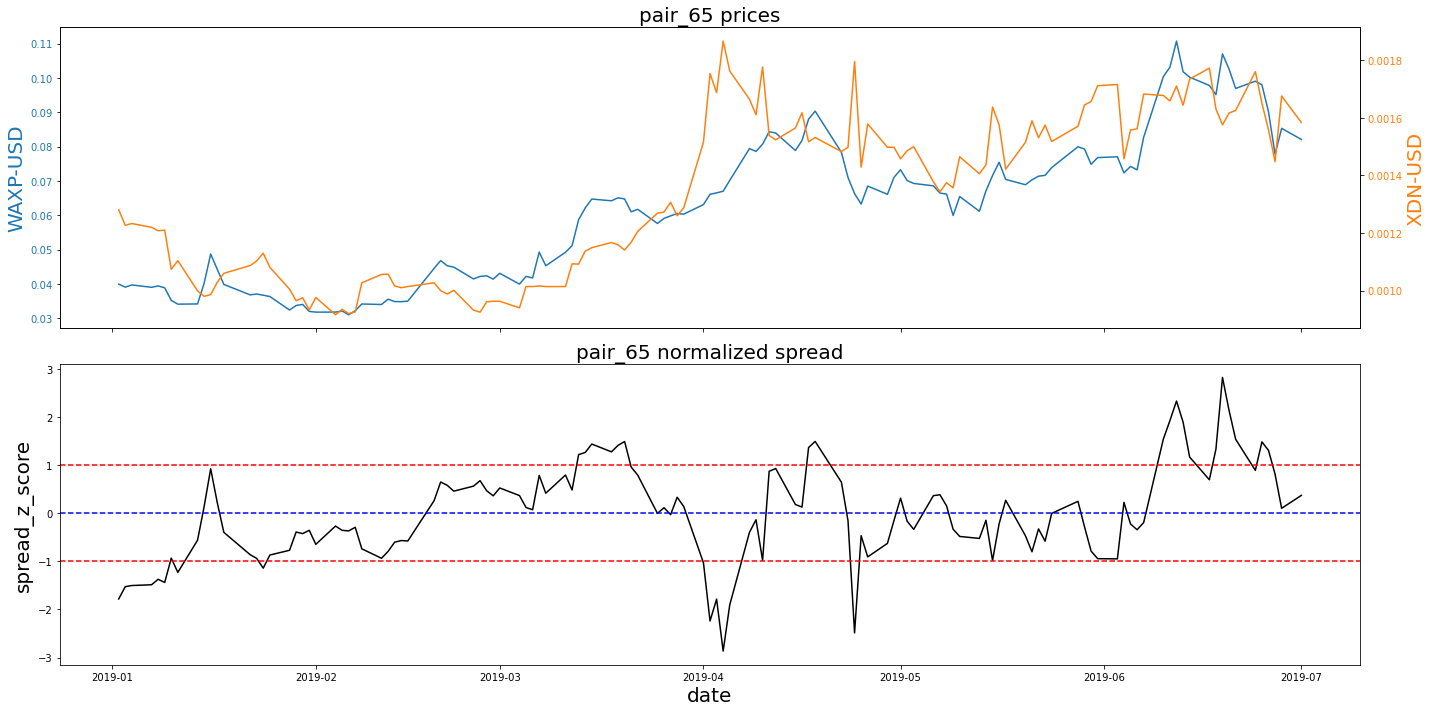

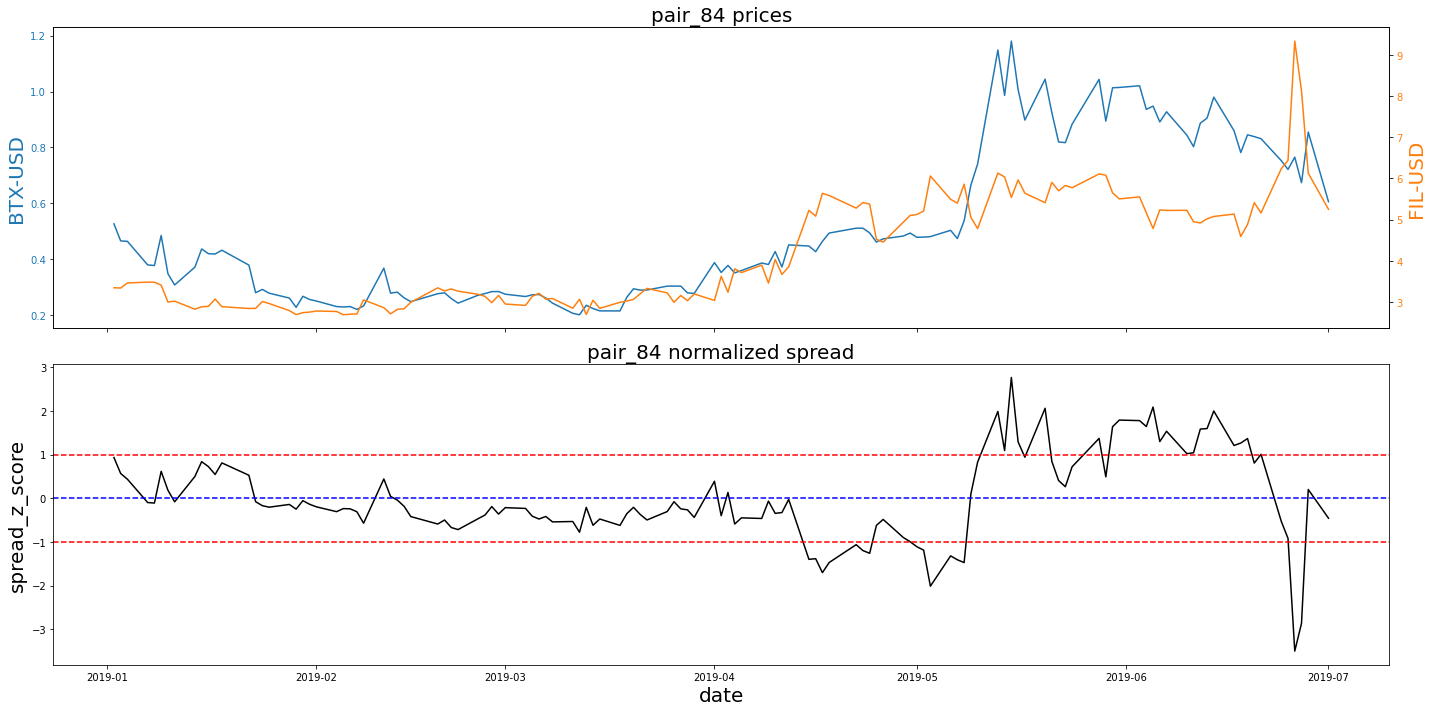

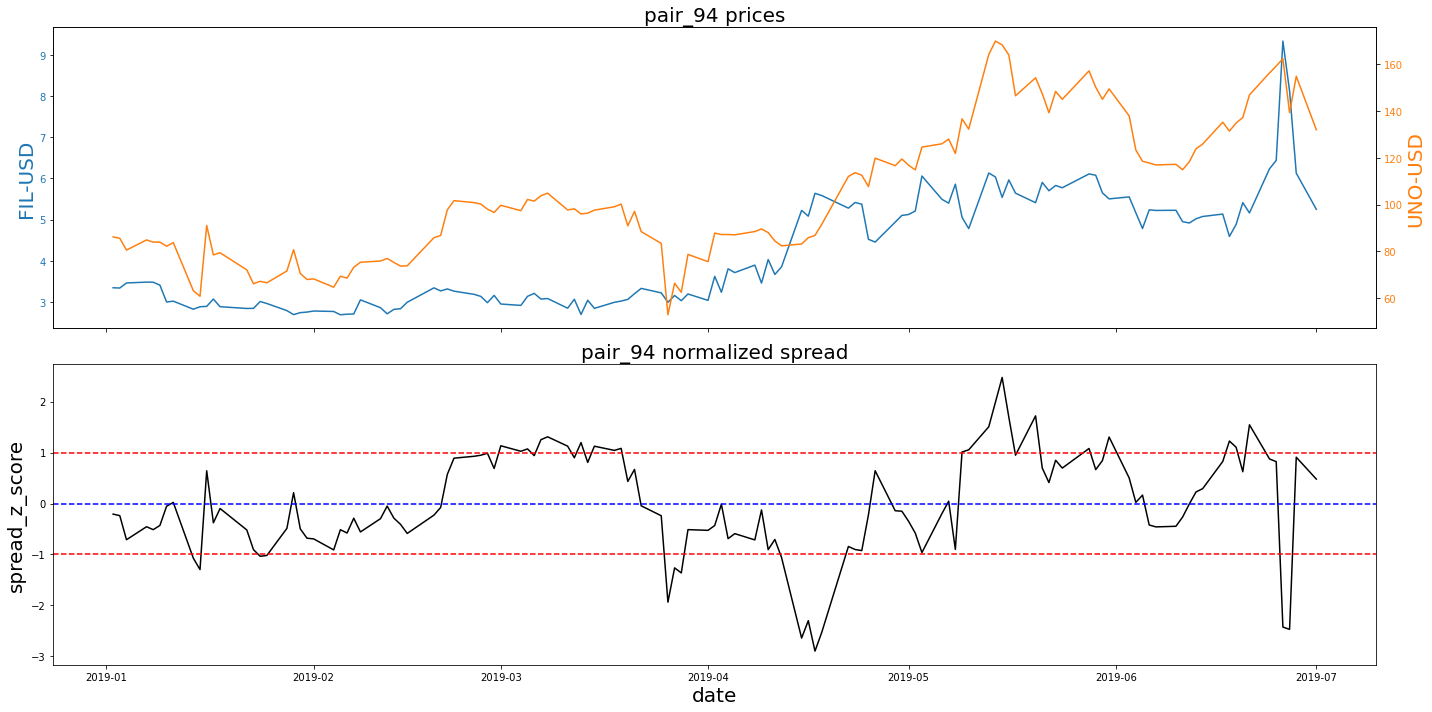

In [88]:
for i in strategy.filtered_pairs.index[:5]:
    strategy.plot_pair_price_spread(idx=i)